# Transcription of a plain neural network into a C function

Let's try to create a simple neural network to identify hand-written digits and to export it in C to be able to use it from any C or C++ application. 

There are a lot of fancier solutions out there, but most of them require dependencies, while in this example we will enclose everything in a single header file.
In any case, this may have some pedagogical value, but we do not suggest using this approach in real applications.

Let's start loading the dataset.

In [1]:
import numpy as np
from sklearn.datasets import load_digits
digits = load_digits()
print (digits.data.shape)
import matplotlib.pyplot as plt

print (dir(digits))

plt.gray()
plt.imshow (1-digits.data[0].reshape((8,8)))

print ( "This is a %d" % digits.target[0] )

(1797, 64)
['DESCR', 'data', 'images', 'target', 'target_names']
This is a 0


Then we transform the label that indicates the digit that is represented in the dataset with the "one-hot" encoding. 
In some sense, we unroll the possible categories into a vector. In this way each category will be associated with a probability variable representing that the probability that a given entry belongs to that category. 

When creating a labels, we know the category, hence we set one of the probability variables to one and let all the other to be null. 

In [2]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False, categories = 'auto', handle_unknown='ignore')
encoder.fit ( np.c_[np.arange(10)] )
print (encoder.categories_)
print (encoder.transform ( np.c_[[2,3,11]] ))

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])]
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


We are now ready to train our simple neural network. 
We will define it as a Multi-Layer Perceptron with few neurons and a single hidden layer. 
The number of neurons in the layer must be the same as the number of categories, in our case digits span the range 0-9, so we have 10 different categories and 10 neurons in the output layer. 

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.



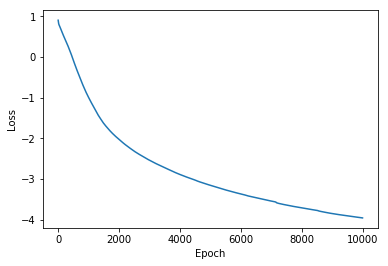

In [3]:
import tensorflow as tf
model = tf.keras.models.Sequential()
model . add ( tf.keras.layers.Dense(10, activation='tanh') )
model . add ( tf.keras.layers.Dense(10, activation='sigmoid') )


model.compile ( 'adam', 'categorical_crossentropy' )
model.build ( (None,64) )
losses = []
from tqdm import tnrange
for iEpoch in tnrange(10000, desc='training', unit='epoch'):
  losses.append ( model.train_on_batch ( digits.data, encoder.transform(np.c_[digits.target]) ))
  
plt.plot (np.arange(len(losses)), np.log(losses))
plt.xlabel("Epoch")
plt.ylabel('Loss')
plt.show()

Let's have a look to the result of the training studying some statistics on the error rates. 
To do things in a honest waym the training sample should be statistically independent of the validation sample that we are using to do the training, otherwise it becomes impossible to check whether the trained model generalizes properly to entries not included in the training set. 
However, in this example we are trying to get a tiny neural network with decent performance so that we consider highly unlikely to get an overtrained network and we prefer to exploit the whole, tiny dataset available for training. 

For real applications where you care about the result, this wouldn't be not a great strategy, though. 

Failed rate: 10/1797


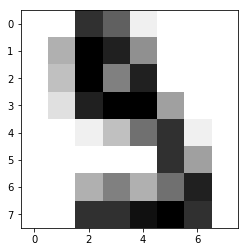

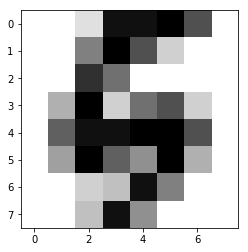

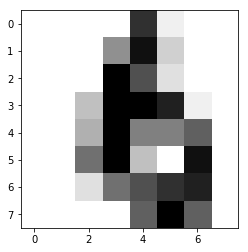

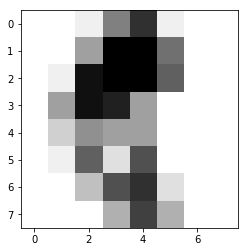

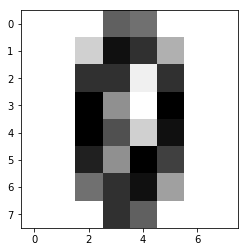

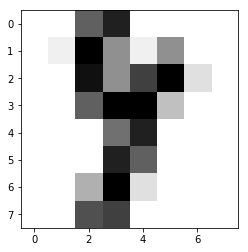

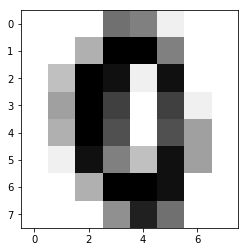

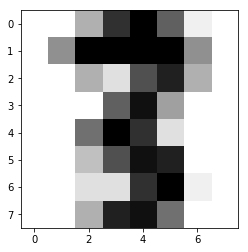

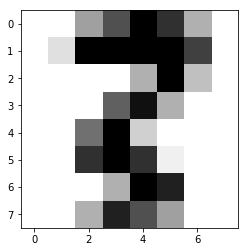

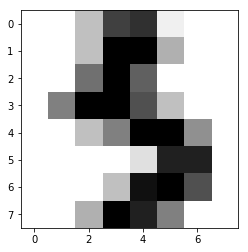

In [4]:
pred_digit = encoder.inverse_transform(model.predict ( digits.data ))
failures = digits.target != pred_digit[:,0]
print ("Failed rate: %d/%d" % (np.count_nonzero(failures), len(digits.target) ))

for example in digits.data[failures][:10]:
  plt.imshow ( 1-example.reshape((8,8)) )
  plt.show()


### Translate in C

Let's do it!

The cell below, generates a C code converting the structure of the neural network into a function that is then saved into a header file. The weights of the neural network are hard-coded in the header file and are therefore converted into binary code at compile time. 

Let's assume to save this header into a file named  `generated_code.h`.

In [5]:
print ("""
// Select all (Ctrl+A), Copy (Ctrl+C), paste to an empty text file (Ctrl+V) and save that file as 'generated_code.h'
// 
// Auto-generated header file. Assumes img to be a floating point array
// of 64 elements (corresponding to an 8x8 b&w image)

#include <math.h>

""")

for iLayer, layer in enumerate(model.layers):
  kernel, bias = layer.get_weights()
  print ("inline float activation_%d (float x) " % iLayer);
  activation =  layer.get_config()['activation'] 
  if activation == 'sigmoid':
    print ("{ return 1./(1 + exp(-x)); }")
  elif activation == 'tanh':
    print ("{ return tanh(x);}")
  elif activation == 'relu':
    print ("{ return x > 0 ? x : 0;}")
  elif activation == 'linear':
    print ("{ return x;}")
  else:
    raise KeyError ("Unexpected activation %s"%activation)
  

  
print ("""
int guess_digit (const float *img)
{
""")

max_out = 64
for iLayer, layer in enumerate(model.layers):
  print ("  // Declare the arrays in the stack")
  kernel, bias = layer.get_weights()
   
  max_out = max(kernel.shape[1], max_out)
  print ("  //",bias.shape)
  kernel_values = "{%s}"%(',\n   '.join(["{%s}"%(','.join(["%18.13f"%x for x in row])) for row in kernel]))
  bias_values   = "{%s}"% ( ",".join(["%18.13f"%x for x in bias]))
  print ("  const float kernel_%d[%d][%d] = \n  %s;" % (iLayer, kernel.shape[0], kernel.shape[1],kernel_values))
  print ("  const float bias_%d[%d] = %s;" % (iLayer, bias.shape[0], bias_values))
  
print ("  float buffer_in[%d];" % max_out)
print ("  float buffer_out[%d];" % max_out)

print ("  unsigned int i,j,c; ")

print ("\n\n\n")
print ("  // Load the input in the buffer")
print ("  for (c = 0; c < 64; ++c) \n  buffer_in[c] = img[c];")

for iLayer, layer in enumerate(model.layers):
  kernel, bias = layer.get_weights()

  print ( "  // Processing layer %i " % iLayer )
  print ( """
  for (c = 0; c < {n_out}; ++c ) 
    buffer_out[c] = bias_{iLayer}[c];
    
  for (c = 0; c < {n_out}; ++c )
    for (i = 0; i < {n_in}; ++i)
      buffer_out[c] += buffer_in[i] * kernel_{iLayer}[i][c];
  
  // Prepares for next layer 
  for (c = 0; c < {n_out}; ++c )
    buffer_in[c] = activation_{iLayer}(buffer_out[c]);
    
  """.format (
      n_in = kernel.shape[0],
      n_out = kernel.shape[1],
      iLayer = iLayer,
  ))
  
last_kernel, last_bias = model.layers[-1].get_weights()
print ("""
  i = 0;
  for (c = 0; c < {n_out}; ++c)
    if (buffer_in[c] > buffer_in[i])
      i = c;
  
  return i;
""".format(n_out = last_kernel.shape[1]))

print ("}")


// Select all (Ctrl+A), Copy (Ctrl+C), paste to an empty text file (Ctrl+V) and save that file as 'generated_code.h'
// 
// Auto-generated header file. Assumes img to be a floating point array
// of 64 elements (corresponding to an 8x8 b&w image)

#include <math.h>


inline float activation_0 (float x) 
{ return tanh(x);}
inline float activation_1 (float x) 
{ return 1./(1 + exp(-x)); }

int guess_digit (const float *img)
{

  // Declare the arrays in the stack
  // (10,)
  const float kernel_0[64][10] = 
  {{   0.0737064182758,   0.0968196690083,   0.0913909077644,   0.1327309310436,  -0.2031657695770,   0.0434923171997,  -0.0546902865171,  -0.0386888235807,   0.0698325335979,   0.2169237434864},
   {   0.6470997333527,   2.7389824390411,   0.6590318083763,   0.4945499002934,  -0.2187254726887,  -0.9348764419556,  -1.6740446090698,   0.2740749418736,  -0.3159315288067,  -0.0968921482563},
   {  -0.0546419396996,   0.5105188488960,  -0.1169735342264,  -0.2762475311756,   0.01115625910

The following main function allows to test the neural network in C, interactively.
It compiles with gcc.


```
#include "generated_code.h"
#include <stdio.h>
#include <stdlib.h>

int main ( int argc, char *argv[] )
{
  float input [ 66 ];
  int c;
  int guessed_digit;

  if (argc != 65)
  {
    printf ( "Wrong number of arguments, expecting 64 got %d\n\n", argc -1 );
    return 1;
  }

  for (c = 0; c < 64; ++c)
    input [ c ] = atof(argv[c+1]);

  guessed_digit = guess_digit ( input );

  printf ( "I guess this is a: %d.\n\n", guessed_digit );

}
```



### Testing the exported network

Now, to test the statistics of the neural network we will need to make the dataset available to our C application.

Since I am too lazy to write C code to read a ASCII file represeting an image, I will use the same technique described above for writing the dataset into another header file that can be directly converted into binary data from the compiler and resides in the memory program without loading it at run time from a file. 

I will assume this second file will be stored in `test_data.h`.

In [6]:
test_data = ""
for data in digits.data:
  test_data += "{%s},\n " % ( "," . join(["%2.0f"%x for x in data]) ) 
test_data = "{%s}" % test_data

test_data_h = """
//Auto-generated C code. Paste it into 'test_data.h'
const unsigned int N_TEST = {dimx};
const float test_data [{dimx}][{dimy}] = 
{dataset};

const int target [{dimx}] = 
{target};
""".format ( 
    dimx = digits.data.shape[0], 
    dimy = digits.data.shape[1], 
    dataset=test_data,
    target = "{%s}"%(','.join(["%2.0f"%x for x in digits.target]))
 )



print (test_data_h)


//Auto-generated C code. Paste it into 'test_data.h'
const unsigned int N_TEST = 1797;
const float test_data [1797][64] = 
{{ 0, 0, 5,13, 9, 1, 0, 0, 0, 0,13,15,10,15, 5, 0, 0, 3,15, 2, 0,11, 8, 0, 0, 4,12, 0, 0, 8, 8, 0, 0, 5, 8, 0, 0, 9, 8, 0, 0, 4,11, 0, 1,12, 7, 0, 0, 2,14, 5,10,12, 0, 0, 0, 0, 6,13,10, 0, 0, 0},
 { 0, 0, 0,12,13, 5, 0, 0, 0, 0, 0,11,16, 9, 0, 0, 0, 0, 3,15,16, 6, 0, 0, 0, 7,15,16,16, 2, 0, 0, 0, 0, 1,16,16, 3, 0, 0, 0, 0, 1,16,16, 6, 0, 0, 0, 0, 1,16,16, 6, 0, 0, 0, 0, 0,11,16,10, 0, 0},
 { 0, 0, 0, 4,15,12, 0, 0, 0, 0, 3,16,15,14, 0, 0, 0, 0, 8,13, 8,16, 0, 0, 0, 0, 1, 6,15,11, 0, 0, 0, 1, 8,13,15, 1, 0, 0, 0, 9,16,16, 5, 0, 0, 0, 0, 3,13,16,16,11, 5, 0, 0, 0, 0, 3,11,16, 9, 0},
 { 0, 0, 7,15,13, 1, 0, 0, 0, 8,13, 6,15, 4, 0, 0, 0, 2, 1,13,13, 0, 0, 0, 0, 0, 2,15,11, 1, 0, 0, 0, 0, 0, 1,12,12, 1, 0, 0, 0, 0, 0, 1,10, 8, 0, 0, 0, 8, 4, 5,14, 9, 0, 0, 0, 7,13,13, 9, 0, 0},
 { 0, 0, 0, 1,11, 0, 0, 0, 0, 0, 0, 7, 8, 0, 0, 0, 0, 0, 1,13, 6, 2, 2, 0, 0, 0, 7,15, 0, 9,

Il file `main_test.c` contiene un programmino per usare questo campione per mettere alla prova la rete neurale.

```
#include "generated_code.h"
#include "test_data.h"
#include <stdio.h>
#include <stdlib.h>

int main (void)
{
  int c = 0;
  const int N = N_TEST;

  int failures = 0;
  for (c = 0; c < N; ++c)
    if ( guess_digit ( test_data[c] ) != target[c] )
      failures ++;

  printf ( "Number of failures %d / %d.\n", failures, N );
}

```

## Conclusion

We discussed a simple approach to convert a simple neural network into a C header file. 
While not very professional, the exercise shed light on the internal behaviour of the neural network. 

The approach can be interesting to push simple neural network into frameworks where libraries are too difficult to interact with. For example Arduino or other microcontroller with (at least) fixed point algebra capabilities. 
We have explored this approach to compile a neural network for FPGA using HLS languages. 

Note that in the implementation discussed here, only MLP can be converted, but the mechanism can be easily expanded to convert other layers, making the approach viable for more complicated neural networks. 